<a href="https://colab.research.google.com/github/iceboxi/Colaboratory/blob/master/digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 手寫數字分類
source: 
* https://www.kaggle.com/c/digit-recognizer/overview

* MNIST
```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```

## 下載資料

In [2]:
#Set the enviroment variables
import os
import pandas as pd
df = pd.read_json('./kaggle.json', typ='series')

os.environ['KAGGLE_USERNAME'] = df['username']
os.environ['KAGGLE_KEY'] = df['key']
!kaggle competitions download -c digit-recognizer

 82% 60.0M/73.2M [00:00<00:00, 109MB/s] 
100% 73.2M/73.2M [00:00<00:00, 149MB/s]
 78% 38.0M/48.8M [00:00<00:00, 89.3MB/s]
100% 48.8M/48.8M [00:00<00:00, 139MB/s] 
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 21.1MB/s]


## import

In [3]:
# Imports for Deep Learning
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, PReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# ensure consistency across runs
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

import os, shutil
from os import listdir
from numpy import floor
import random
import numpy as np
import pandas as pd

# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

In [0]:
plt.style.use('default')

## 讀取資料

In [0]:
print(os.getcwd())

/content


In [0]:
train2 = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)
train1 = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submit = pd.read_csv('./sample_submission.csv')

In [0]:
new_cols = {x: y for x, y in zip(train2.columns, train1.columns)}
train = pd.concat([train1, train2.rename(columns=new_cols)], axis=0, ignore_index=True)

In [39]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 查看data

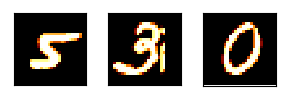

In [40]:
def plot_three_samples():
    plt.figure(figsize=(3,3))
    imgs = [random.randint(0, np.size(train, 0)) for _ in range(0, 3)]
    
    for digit_num in range(0,3):
        plt.subplot(1,3,digit_num+1)
        grid_data = train.iloc[imgs[digit_num],1:].values.reshape(28,28)  # reshape from 1d to 2d pixel array
        plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
        plt.xticks([])
        plt.yticks([])
        
    plt.tight_layout()
    return

plot_three_samples()

## 設定常數

In [0]:
target_dims = (28, 28, 1)
n_classes = 10
batch_size = 1024
val_frac = 0.1
seed = 24
epochs = 50

## 分割訓練與測試集

In [0]:
train_data = train.iloc[:,1:]
target = train.iloc[:,0]

In [0]:
# target_onehot = to_categorical(target, num_classes=n_classes) # one-hot，不一定需要
### 使用後差異會在兩個地方，一個是分割測試來源時，target不取valurs，
### model的 loss 改用 categorical_crossentropy 而不是 sparse_categorical_crossentropy

In [0]:
x_train , x_test , y_train , y_test = train_test_split(train_data.values , target.values , test_size = 0.1, random_state = seed) 

In [0]:
x_train_normalized = x_train.reshape(-1 , 28 , 28 , 1)/255
x_test_normalized = x_test.reshape(-1 , 28 , 28 , 1)/255

In [0]:
y_train_onehot = to_categorical(y_train, num_classes=n_classes)
y_test_onehot = to_categorical(y_test, num_classes=n_classes)

In [46]:
print(x_train_normalized.shape, y_train_onehot.shape, test.shape)

(46800, 28, 28, 1) (46800, 10) (28000, 784)


## AI訓練

### 定義model

In [0]:
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(4, 4), strides=(2,2), input_shape=target_dims))
    model.add(PReLU())
    model.add(layers.Dropout(0.5))
    model.add(BatchNormalization())
    #model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (4, 4), strides=(2,2)))
    model.add(PReLU())
    model.add(layers.Dropout(0.5))
    model.add(BatchNormalization())
    #model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1)))
    model.add(PReLU())
    model.add(layers.Dropout(0.5))
    model.add(BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(PReLU())
    model.add(layers.Dropout(0.25))
    model.add(BatchNormalization())
    model.add(layers.Dense(512))
    model.add(PReLU())
    model.add(layers.Dropout(0.25))
    model.add(BatchNormalization())
    model.add(layers.Dense(256))
    model.add(PReLU())
    model.add(layers.Dropout(0.25))
    model.add(BatchNormalization())
    model.add(layers.Dense(128))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(layers.Dense(n_classes, activation='sigmoid'))
    return model

In [0]:
def cnn_model1():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = target_dims))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (2,2), padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation = "softmax"))
    return model

In [0]:
def cnn_model2():
    model = Sequential()

    model.add(Conv2D(16, (5,5), activation="relu", padding="same", data_format="channels_last", input_shape=target_dims))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))

    model.add(Conv2D(32, (5,5), activation="relu", padding="same", data_format="channels_last"))
    model.add(MaxPooling2D(pool_size=(2,2), data_format="channels_last"))

    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="softmax"))
    return model

In [0]:
model = cnn_model()

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
p_re_lu_14 (PReLU)           (None, 13, 13, 32)        5408      
_________________________________________________________________
dropout_12 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_v1_14 (B (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
p_re_lu_15 (PReLU)           (None, 5, 5, 64)          1600      
_________________________________________________________________
dropout_13 (Dropout)         (None, 5, 5, 64)          0         
__________

In [0]:
# 定義訓練方式
# loss function: 交叉熵
# optimizer: Adam
# 評估模型: 準確率
# model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [0]:
optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### 設定data generator

In [0]:
datagen = ImageDataGenerator(
                              featurewise_center = False,  # set input mean to 0 over the dataset
                              samplewise_center = False,  # set each sample mean to 0
                              featurewise_std_normalization = False,  # divide inputs by std of the dataset
                              samplewise_std_normalization = False,  # divide each input by its std
                              zca_whitening = False,  # apply ZCA whitening
                              rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
                              zoom_range = 0.1, # Randomly zoom image 
                              width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
                              horizontal_flip = False,  # randomly flip images
                              vertical_flip = False, # randomly flip images
                              validation_split = val_frac
                            )

### 設定 callback

用來調整learning rate加強學習效果

In [0]:
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=2, # 三個epoch沒有進展
                                 verbose=1, 
                                 factor=0.5, # 縮小一半的learning rate
                                 min_lr=0.00001 # 最小下降幅度
                                )

In [0]:
es = EarlyStopping(monitor='val_acc', 
                   mode='max', 
                   verbose=1, 
                   patience=50, 
                   restore_best_weights=True
                  )

In [0]:
lrs = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

### 訓練

In [0]:
train_history = model.fit(x_train_normalized, y_train_onehot, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)

In [0]:
datagen.fit(x_train_normalized)

train_generator = datagen.flow(x_train_normalized, y_train_onehot, batch_size = batch_size)
train_history = model.fit_generator(train_generator,
                                    steps_per_epoch = x_train_normalized.shape[0],
                                    validation_data = (x_test_normalized, y_test_onehot), # 訓練同時測試
                                    epochs = epochs,
                                    verbose = 1,
                                    callbacks = [lr_reduction, es]
                                   )

In [32]:
final_loss, final_acc = model.evaluate(x_test_normalized, y_test_onehot, verbose=0) # 其他測試方式
print('loss =' , final_loss , '\naccuracy' , final_acc)

loss = 0.005584231955894771 
accuracy 0.9982693


In [0]:
model.save_weights("model.h5")

### 完整範例流程

In [0]:
# model = cnn_model1()
model = cnn_model2()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               200832    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
__________

In [31]:
# 直接使用來源資料
train_history = model.fit(x_train_normalized, 
                          y_train_onehot, 
#                           validation_split = 0.2, # 沒有驗證集的時候使用的
                          epochs = epochs, 
                          batch_size = batch_size, 
                          verbose=1,
                          callbacks = [lr_reduction, es],
                          validation_data = (x_test_normalized, y_test_onehot)
                         )

Train on 46800 samples, validate on 5200 samples
Epoch 1/50
46800/46800 [==============================] - 62s 1ms/sample - loss: 0.6719 - acc: 0.6278 - val_loss: 0.7150 - val_acc: 0.8254
Epoch 2/50
46800/46800 [==============================] - 59s 1ms/sample - loss: 0.3587 - acc: 0.9006 - val_loss: 0.7123 - val_acc: 0.8417
Epoch 3/50
46800/46800 [==============================] - 60s 1ms/sample - loss: 0.1483 - acc: 0.9739 - val_loss: 0.5970 - val_acc: 0.8504
Epoch 4/50
46800/46800 [==============================] - 59s 1ms/sample - loss: 0.0759 - acc: 0.9837 - val_loss: 0.4731 - val_acc: 0.8771
Epoch 5/50
46800/46800 [==============================] - 58s 1ms/sample - loss: 0.0523 - acc: 0.9871 - val_loss: 0.3127 - val_acc: 0.9083
Epoch 6/50
46800/46800 [==============================] - 58s 1ms/sample - loss: 0.0411 - acc: 0.9892 - val_loss: 0.2052 - val_acc: 0.9314
Epoch 7/50
46800/46800 [==============================] - 58s 1ms/sample - loss: 0.0344 - acc: 0.9905 - val_loss: 0.1

In [0]:
# 使用generator來增加測試資料
datagen.fit(x_train_normalized)

train_generator = datagen.flow(x_train_normalized, y_train_onehot, batch_size = batch_size)
train_history = model.fit_generator(train_generator,
                                    steps_per_epoch = x_train_normalized.shape[0],
                                    validation_data = (x_test_normalized, y_test_onehot), # 訓練同時測試
                                    epochs = epochs,
                                    verbose = 1,
                                    callbacks = [lr_reduction, es]
                                   )

## 圖形化訓練結果

In [0]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train], label = train)
    plt.plot(train_history.history[validation], label = validation)
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel('Epoch')
    return

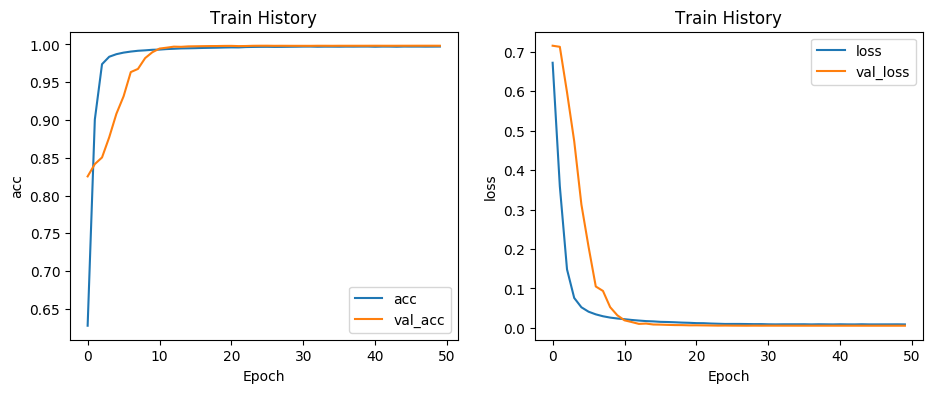

In [34]:
plt.figure(figsize=(11, 4))

plt.subplot(1, 2, 1)
show_train_history(train_history, 'acc', 'val_acc')
plt.legend()

plt.subplot(1, 2, 2)
show_train_history(train_history, 'loss', 'val_loss')
plt.legend()

## 檢視驗證集

In [0]:
results = model.predict(x_test_normalized)
results = np.argmax(results , axis = 1)
cm = confusion_matrix(y_test, results)

In [0]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

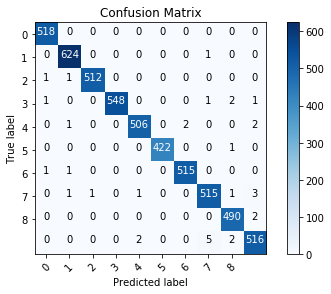

In [63]:
plot_confusion_matrix(cm, range(0, 9))

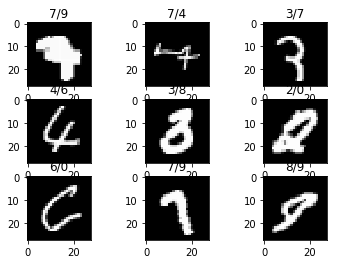

In [64]:
incorrect = np.where(y_test != results)[0]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    idx = incorrect[i]
    img = x_test[idx].reshape(28,28)
    plt.imshow(img, cmap="gray")
    plt.title("{}/{}".format(y_test[idx], results[idx]))

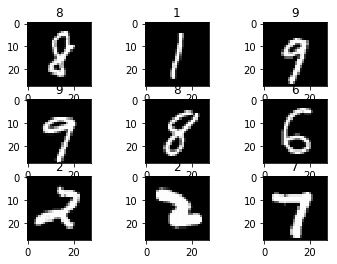

In [0]:
correct = np.where(y_test == results)[0]
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    idx = correct[i]
    img = x_test[idx].reshape(28,28)
    plt.imshow(img, cmap="gray")
    plt.title("{}".format(y_test[idx]))

## 預測與準備上傳檔案

In [0]:
test = test.values
test = test.reshape(-1 , 28 , 28 ,1)/255

In [0]:
pre = model.predict(test, batch_size=batch_size)

In [0]:
pre = np.argmax(pre , axis = 1)

In [37]:
pre

array([2, 0, 9, ..., 3, 9, 2])

In [0]:
submit.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [0]:
submit['Label'] = pre

In [0]:
submit.to_csv('submit.csv' , index= False)

## 心得

增加準確率的方法大概有
1. 調整model層數
2. 增加epoch的次數，但要注意overfitting的問題
3. 利用ImageDataGenerator產生額外資料來做訓練

另外也可以調整learning_rate的方法，優化結果與調適時間
 
ref. https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-ii-learning-rate-3iawu